In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1' #seems to work with only one GPU aswell
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)
# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2
# ------------------------------------------ import helpers
# Notebook_imports should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D, show_phases, show_phases_transpose
from src.utils.KerasCallbacks import get_callbacks
from src.data.Dataset import get_trainings_files
from src.data.Generators import DataGenerator
import src.models.Loss_and_metrics as metr

# import external libs
import cv2
import pandas as pd

# import libs for cross_val

#from sklearn.model_selection import RepeatedKFold
#from sklearn.model_selection import cross_val_score



EXPERIMENT = 'temp/TeaMRT_Exp_3_Softmax/'
#EXPERIMENT = 'baseline_label_transpose_smooth05/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_NOaug_b8'
# EXPERIMENT = 'mased_scores/36_5_BiLSTM32_NoBn_conv5_size1_CCE_NOphaseaug_shift_rotate_reflectbordersgridaug'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # add a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the input data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number
# Finally the path to the metadata
DATA_PATH_SAX = '/mnt/ssd/data/WFT_MRT21/Export_2021-05-26_16_03' # used for main training: # alt: Export_random_100_new_2021-07-08_08_50
DF_FOLDS = '/mnt/ssd/data/WFT_MRT21/df_kfold.csv' #'/mnt/ssd/data/acdc/2D/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase'
FOLD = 3 # a total of 4 folds across 100 patients, each with 5 cases of each of the 5 pathologies

# General params
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 8 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
EPOCHS = 500

DIM = [128, 128] # network input shape for spacing of 3, (z,y,x)
SPACING = [1.8, 1.8] # if resample, resample to this spacing, (z,y,x)

# Model params
DEPTH = 4 # depth of the encoder
FILTERS = 32 # initial number of filters, will be doubled after each downsampling block
M_POOL = [2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3] # conv filter size
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'relu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
REDUCE_LR_ON_PLAEAU_PATIENCE = 5
DECAY_FACTOR = 0.7 # Define a learning rate decay for the ReduceLROnPlateau callback
POLY_LR_DECAY = False
MIN_LR = 1e-12 # minimal lr, smaller lr does not improve the model
DROPOUT_MIN = 0.3 # lower dropout at the shallow layers
DROPOUT_MAX = 0.5 # higher dropout at the deep layers

# Callback params
MONITOR_FUNCTION = 'loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
SAVE_LEARNING_PROGRESS_AS_TF = True

# Generator and Augmentation params
IMG_CHANNELS = 1
MASK_VALUES = [1, 2]  #channel order: Background, upper rvip, lower rvip
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8 # will be randomely applied to 80% of the files with a random other histogram
SHUFFLE = True
RESAMPLE = True
HIST_MATCHING = False
SCALER = 'MinMax' # MinMax, Standard or Robust

# Check if these channels are given
metrics = [
    metr.dice_coef_labels, #LA combination channel
    metr.dice_coef_lower, #former Myo
    metr.dice_coef_upper, #former LV
    #metr.dice_coef_rv #LA third channel
]

#LOSS_FUNCTION = #metr.bce_dice_loss

Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/wft21_septum_landmark_detection
['/gpu:0', '/gpu:1']


2021-07-08 09:48:16,745 INFO -------------------- Start --------------------
2021-07-08 09:48:16,746 INFO Working directory: /mnt/ssd/git/wft21_septum_landmark_detection.
2021-07-08 09:48:16,746 INFO Log file: ./logs/temp/TeaMRT_Exp_3_Softmax/.log
2021-07-08 09:48:16,746 INFO Log level for console: INFO
2021-07-08 09:48:16,747 INFO Is built with tensorflow: True
2021-07-08 09:48:16,776 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/TeaMRT_Exp_3_Softmax/', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/temp/TeaMRT_Exp_3_Softmax/2021-07-08_09_48', 'MODEL_PATH': 'exp/temp/TeaMRT_Exp_3_Softmax/2021-07-08_09_48/model', 'TENSORBOARD_PATH': 'exp/temp/TeaMRT_Exp_3_Softmax/2021-07-08_09_48/tensorboard_logs', 'CONFIG_PATH': 'exp/temp/TeaMRT_Exp_3_Softmax/2021-07-08_09_48/config', 'HISTORY_PATH': 'exp/temp/TeaMRT_Exp_3_Softmax/2021-07-08_09_48/history', 'DATA_PATH_SAX': '/mnt/ssd/data/WFT_MRT21/Export_2021-05-26_16_03', 'DF_FOLDS': '/mnt/ssd/data/WFT_MRT21/df_kfold.csv', 'DF_META': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/SAx_3D_dicomTags_phase', 'FOLD': 3, 'BATCHSIZE': 8, 'GENERATOR_WORKER': 8, 'EPOCHS': 500, 'DIM': [128, 128], 'SPACING': [1.8, 1.8], 'DEPTH': 4, 'FILTERS': 32, 'M_POOL': [2, 2], 'F_SIZE': [3, 3], 'BN_FIRST': False, 'BATCH_NORMALISATION': True, 'PAD': 'same', 'KERNEL_INIT': 'he_normal', 'OPTIMIZER': 'adam', 'ACTIVATION': 'relu

2021-07-08 09:48:17,112 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9206645651594848295
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14742119734501817410
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 18367988675375493590
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22774262016
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4041532102738183272
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [2]:
# Load SAX volumes
x_train, y_train, x_val, y_val =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train), len(y_train)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val), len(y_val)))

# create a batch generator
batch_generator = DataGenerator(x_train, y_train, config=config)
val_config = config.copy()
val_config['AUGMENT_GRID'] = False# make sure no augmentation will be applied to the validation data
val_config['AUGMENT'] = False
val_config['HIST_MATCHING'] = False
validation_generator = DataGenerator(x_val, y_val , config=val_config)

2021-07-08 09:48:17,158 INFO Found 1902 images/masks in /mnt/ssd/data/WFT_MRT21/Export_2021-05-26_16_03
2021-07-08 09:48:17,158 INFO Patients train: 75
2021-07-08 09:48:17,218 INFO Selected 1406 of 1902 files with 75 of 100 patients for training fold 3
2021-07-08 09:48:17,218 INFO SAX train CMR: 1406, SAX train masks: 1406
2021-07-08 09:48:17,219 INFO SAX val CMR: 496, SAX val masks: 496
2021-07-08 09:48:17,219 INFO Create DataGenerator
2021-07-08 09:48:17,224 INFO Datagenerator created with: 
 shape: [128, 128]
 spacing: [1.8, 1.8]
 batchsize: 8
 Scaler: MinMax
 Images: 1406 
 Augment: True 
 Thread workers: 8
2021-07-08 09:48:17,225 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-07-08 09:48:17,226 INFO Create DataGenerator
2021-07-08 09:48:17,228 INFO Datagenerator created with: 
 shape: [128, 128]
 spacing: [1.8, 1.8]
 batchsize: 8
 Scaler: MinMax
 Images: 496 
 Augment: False 
 Thread workers: 8
2021-07-08 09:48:17,228 INFO No augmentation


## Visualize one batch

In [3]:
generator = validation_generator
@interact
def select_image_in_batch(batch = (0,len(generator), 1), im = (0,BATCHSIZE- 1, 1), slice_n=(1,11), save=False, filepath='data/temp/', filename='temp_x.npy'):
    
    global x, y
    x, y = generator.__getitem__(batch)
    info('selected batch : ' + str(batch))
    # logging level == debug --> visualise the generator steps
    info('X shape: {}, Y shape: {}'.format(x.shape, y.shape))
    show_2D_or_3D(x[im], y[im], interpol='bilinear',dpi=100,f_size=(5,5))
    plt.show()
    
    plt.hist(x[im].flatten())
    plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))

interactive(children=(IntSlider(value=31, description='batch', max=62), IntSlider(value=3, description='im', m…

In [4]:
# # experimental # Train Cross validation
# import src.models.Unets as modelmanager
# folds = [i for i in range(0, 4, 1)]

# for f in folds:
#     info('starting fold: {}'.format(f))
#     config_ = config.copy()
#     config_['FOLD'] = f
#     #train_fold(config_)
#     timestemp_ = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # add a timestep to each project to make repeated experiments unique
#     config_['EXP_PATH'] = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp_)
    
#     """
#     load past config for model training 
#     """
#     if 'streategy' in locals():
#         pass
#     else:
#         # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
#         strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
#     with strategy.scope():
#     # create new model
#         logging.info('Create model')
#         model = modelmanager.create_unet(config_, metrics, supervision=False)
#         model.summary()
        
    

In [5]:
# experimental

"""
load past config for model training 
"""
if 'streategy' in locals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))

import src.models.Unets as modelmanager
with strategy.scope():
    # create new model
    logging.info('Create model')
    model = modelmanager.create_unet(config, metrics, supervision=False)
    model.summary()

2021-07-08 09:48:17,518 INFO Create model


using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch
(None, 128, 128, 1)
Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 32) 0           batch_normalizatio

# Load an existing config/model

In [6]:
# Load a previous config and by this a pre-trained model
from ipyfilechooser import FileChooser
config_chooser = FileChooser(os.path.join(os.getcwd(),'reports/configs'), 'config.json')
display(config_chooser)

FileChooser(path='/mnt/ssd/git/wft21_septum_landmark_detection/reports/configs', filename='config.json', title…

In [7]:
@interact
def interact_load_pretrained_model(config_file=glob.glob('reports/configs/{}/acdc/finetune/**/*.json'.format(config.get('ARCHITECTURE', '2D')), recursive=False), load=False):
    """
    load past config for model training 
    """
    # load config with all params into global namespace
    from src.models.ModelUtils import load_pretrained_model
    if load:
        with open(config_file, encoding='utf-8') as data_file:
            config_temp = json.loads(data_file.read())
        config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
        logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))
        #logging.info('config:\n {}'.format(json.dumps(config, indent=4, sort_keys=True)))
    
        try:
            # Cell for automation of the model loading process
            # load one basemodel for the finetuning task
            # load model
            globals()['model'] = load_pretrained_model(config_temp, metrics)
            model.summary()
        except Exception as e:
            logging.error(str(e))

interactive(children=(Dropdown(description='config_file', options=(), value=None), Checkbox(value=False, descr…

In [8]:
# read csv script and create 5 data splits according to patient groups

In [9]:
# ## LA Cross-Validation
# # evaluate a logistic regression model using repeated k-fold cross-validation

# # create dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1)
# # prepare the cross-validation procedure
# cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
# # create model
# model = LogisticRegression()
# # evaluate model
# scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# # report performance
# print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

## Create Model

In [10]:
"""
load past config for model training 
"""
if 'streategy' in locals():
    pass
else:
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))

import src.models.Unets as modelmanager
with strategy.scope():
    # create new model
    logging.info('Create model')
    model = modelmanager.create_unet(config, metrics, supervision=False)
    model.summary()

2021-07-08 09:48:18,732 INFO Create model


(None, 128, 128, 1)
Model: "unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 128, 128, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 128, 128, 32) 128         conv2d_22[0][0]                  
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 32) 0           batch_normalization_18[0][0]     
___________________________________________________________________________

In [11]:
# test if all batches are processable
"""for b in range(len(batch_generator)):
    print(b)
    for im in range(BATCHSIZE):
        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)"""

'for b in range(len(batch_generator)):\n    print(b)\n    for im in range(BATCHSIZE):\n        select_image_in_batch(batch=b,im=im, slice_n=5, show_overview=True, show_input_vol=True)'

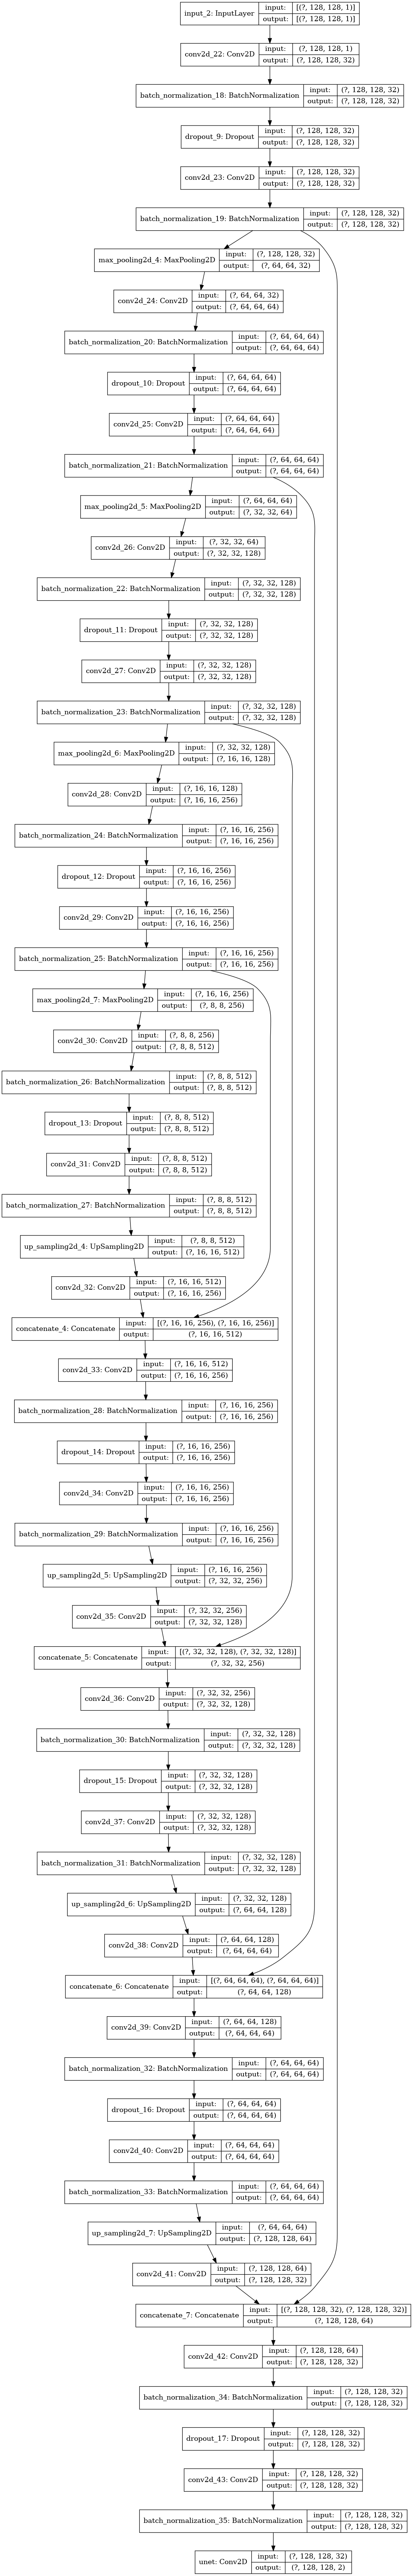

In [12]:
# write the model summary to a txt file
# Open the file
with open(os.path.join(EXP_PATH, 'model_summary.txt') ,'w') as fh:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
    
tf.keras.utils.plot_model(
    model, show_shapes=True,
    to_file=os.path.join(EXP_PATH, 'model.png'),
    show_layer_names=True, 
    rankdir='TB', 
    expand_nested=True, dpi=96
)
    
#model.summary(line_length=150)

In [13]:
initial_epoch = 0

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=initial_epoch,
    max_queue_size=12,
    verbose=1)

2021-07-08 09:48:20,116 INFO feed 4 Tensorboard is ready


Epoch 1/500
175/175 [==============================] - ETA: 0s - loss: 8.1351e-04 - dice_coef_labels: 0.0013 - dice_coef_lower: 0.0012 - dice_coef_upper: 0.0013
Epoch 00001: loss improved from inf to 0.00081, saving model to exp/temp/TeaMRT_Exp_3_Softmax/2021-07-08_09_48/model/model.h5
175/175 [==============================] - 8s 45ms/step - loss: 8.1351e-04 - dice_coef_labels: 0.0013 - dice_coef_lower: 0.0012 - dice_coef_upper: 0.0013 - val_loss: 6.8990e-04 - val_dice_coef_labels: 0.0012 - val_dice_coef_lower: 0.0011 - val_dice_coef_upper: 0.0014 - lr: 1.0000e-04
Epoch 2/500
175/175 [==============================] - ETA: 0s - loss: 1.5063e-04 - dice_coef_labels: 0.0020 - dice_coef_lower: 0.0018 - dice_coef_upper: 0.0022
Epoch 00002: loss improved from 0.00081 to 0.00015, saving model to exp/temp/TeaMRT_Exp_3_Softmax/2021-07-08_09_48/model/model.h5
175/175 [==============================] - 15s 84ms/step - loss: 1.5063e-04 - dice_coef_labels: 0.0020 - dice_coef_lower: 0.0018 - dice_c

# run all cells for training, this cell will terminate the current jupyter process 
## --> free all ressours after the training has finished


In [ ]:
# run all cells for training, this cell will terminate the current jupyter process 
# --> free all ressours after the training has finished
os.system('kill %d' % os.getpid())